<a href="https://colab.research.google.com/github/markriedl/transformer-walkthrough/blob/main/Transformer_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Code Walkthrough

[Mark Riedl](http://eilab.gatech.edu/mark-riedl.html)

This notebook walks through a single forward pass of the Transformer architecture in pytorch. It is meant for illustration and educational purposes only. 

The Transformer was introduced by Vaswani et al. (2017) in their paper, titled [Attention Is All You Need](https://arxiv.org/abs/1706.03762).

# Computation Graph

This is the computation graph, an illustrated diagram of the mathematical operations, their inputs and their outputs. The inputs at the bottom are fed upward into an encode and a decoder (depicted side by side like in a sequence-to-sequence network). At every stage, it shows the matrix and their shapes (excluding the batching dimension, which makes the tensors more complicated looking without adding much information). The bubbles show what part of the code below is responsible for each part of the diagram.

![Computation Graph](https://github.com/markriedl/transformer-walkthrough/raw/main/transformer.png)

# Imports

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

# Hyper parameters

In [77]:
d_embed = 512       # embedding size for the attention modules
num_heads = 8       # Number of attention heads
num_batches = 1     # number of batches (1 makes it easier to see what is going on)
vocab = 50000       # vocab size
max_len = 5000      # Max length of TODO what exactly?
n_layers = 1        # number of attention layers (not used but would be an expected hyper-parameter)
d_ff = 2048         # hidden state size in the feed forward layers
epsilon = 1e-6      # epsilon to use when we need a small non-zero number


#Make dummy data

Here we create some dummy input data, consisting of three tokens. The 2nd token will be the masked token. Initially we have an input `x` of size `batch_size x sequence_length`. Throughout, we will use `x` to denote the tensor that originated from the input sequence, and `y` to denote the tensor that originated from the target sequence. 

In [78]:
x = torch.tensor([[1, 2, 3]]) # input will be 3 tokens
y = torch.tensor([[1, 2, 3]]) # target will be same as the input for many applications
x_mask = torch.tensor([[1, 0, 1]]) # Mask the 2nd input token
y_mask = torch.tensor([[1, 0, 1]]) # Mask the 2nd target token
print("x", x.size())
print("y", y.size())

x torch.Size([1, 3])
y torch.Size([1, 3])


# 1. Encoder

This section shows a walk-through of one attention layer in the encoder. The purpose of the encoder is to create a *hidden state*, an encoded representation of the input sequence. The hidden state is then passed to the decoder.

## 1.1 Encoder Embeddings

Use a conventional embedding layer to convert the tokens into embeddings of size `d_embed`. The embedding activations are then scaled by `sqrt(d_model)` in order to make them bigger. This will be important when positional embedding information is added (next). We want this embedding information to have more importance. The result is a tensor of size `batch_size x sequence_length x embedding_size`.

In [79]:
# Make the embedding module. It understands that each token should result in a separate embedding.
emb = nn.Embedding(vocab, d_embed)
x = emb(x)
# Scale the embedding
x = x * math.sqrt(d_embed)
print(x.size())

torch.Size([1, 3, 512])


Next we add positional embedding information. The code below creates a pattern of overlapping sine and cosine waves that are added to the embedding. This differentiates embedded tokens based on where they are in the sequence. That is, if an input sequence has two of the same token, their embeddings will end up looking a little bit different based on their position in the sequence.

In [80]:
# Start with an empty tensor
pe = torch.zeros(max_len, d_embed, requires_grad=False)
# array containing index values 0...max_len
position = torch.arange(0, max_len).unsqueeze(1)
divisor = torch.exp(torch.arange(0, d_embed, 2) * -(math.log(10000.0) / d_embed))
# Make overlapping sine and cosine wave inside positional embedding tensor
pe[:, 0::2] = torch.sin(position * divisor)
pe[:, 1::2] = torch.cos(position * divisor)
pe = pe.unsqueeze(0)
# Add the position embedding to the main embedding
x = x + pe[:, :x.size(1)]
print(x.size())

torch.Size([1, 3, 512])


To see how positional embeddings work, we can visualize the values that get added to each embedding in each dimension of the embedding (we only visualize the first 8 dimensions).

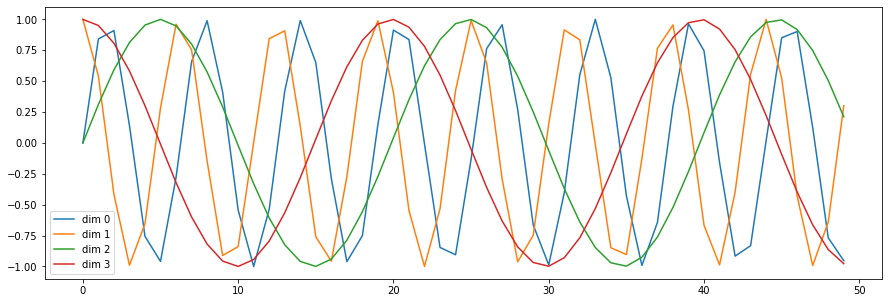

In [81]:
plt.figure(figsize=(15, 5))   # Make a plot
d_embed_plot = 16             # for illustration purposes, set embedding dimensions = 16  
pe_plot = torch.zeros(max_len, d_embed_plot, requires_grad=False) # positional embedding tensor
position_plot = torch.arange(0, max_len).unsqueeze(1)
divisor_plot = torch.exp(torch.arange(0, d_embed_plot, 2) * -(math.log(10000.0) / d_embed_plot))
pe_plot[:, 0::2] = torch.sin(position_plot * divisor_plot)
pe_plot[:, 1::2] = torch.cos(position_plot * divisor_plot)
pe_plot = pe_plot.unsqueeze(0)
# plot it
y_plot = torch.zeros(1, 50, d_embed_plot)
y_plot = pe_plot[:, :y_plot.size(1)]
plt.plot(np.arange(50), y_plot[0, :, 0:4].data.numpy())
plt.legend(["dim %d"%p for p in range(8)])

## 1.2 Encoder Attention Layers

The sub-layers in this section will be repeated N times. This code walkthrough will only take us through one. The Encoder Attention Layers consist of a **self-attention** module followed by a **feed forward** module. 

The self-attention and the feed forward are wrapped with residuals. A residual connection adds the input of a block to the output of the block. Thus one can think of the block as trying to learn how to add or subtract from the input. This provides stability to the training because the block is not entirely responsible for everything that happens in the forward and backward passes. Taking a look at the encoder for the transformer, one can see the residual connections bypassing the self-attention providing a direct linkage to the hidden state. That is, the embedding at the bottom has the option of doing a lot of the heavy-lifting in terms of the final hidden state encoding. Self-attention and the other sub-layers may add a little bit to that final hidden state or a lot if it helps with loss. Another way of thinking about residuals is like sub-routines in conventional computer program that compute some side-effect. One sub-routine computes the final hidden state. Another sub-routine branches off and computes self-attention. But because every module must be on a gradient path, the side-routines must contribute something to the final loss.

### 1.2.1 Self-Attention Module

#### 1.2.1.1 Set aside residual

A residual adds the inputs back into the outputs so that what happens in between can be thought of as computing a delta to the original. 

Typically we don't need to perform a `clone()` to create a residual, but we are using the same `x` variable in every step so the clone makes sure we don't overwrite.

In [82]:
x_residual = x.clone() 
print(x.size())

torch.Size([1, 3, 512])


#### 1.2.1.2 Pre-Self-Attention Layer Normalization

Before we compute self-attention, we perform layer normalization. Layer normalization stabilizes the training by decreasing the chances that values start to go to extremes. This is accomplished by centering all the values relative to the mean.

In [83]:
mean = x.mean(-1, keepdim=True)
std = x.std(-1, keepdim=True)
W1 = nn.Parameter(torch.ones(d_embed))
b1 = nn.Parameter(torch.zeros(d_embed))
x = W1 * (x - mean) / (std + epsilon) + b1
print(x.size())

torch.Size([1, 3, 512])


#### 1.2.1.3 Self-Attention

Self-attention is a process of generating scores that indicate how each token is to every other token. Thus we would expect a `seq_length x seq_length` matrix of values between 0 and 1, each indicating the importance of the i-th token to the j-th token. What does it mean to be "relevant"? Whatever reduces loss. The model must learn how to produce the scores.

A metaphor for understanding self-attention is a hash table. In a hash table, there is a list of keys, each of which is associated with a value. A query is sent to the hash table, and the hash table has to find the matching key and return the associated value. Except imagine that this hash table is a fuzzy hash table in the sense that it the query doesn't have to match any keys and the hash table will return whatever seems closest to the query.

The input to self-attention is a `batch_size x sequence_length x embedding_size` matrix. Ignoring the batching dimension, what we have is a sequence of embedded tokens. Self-attention copies this input, `x`, three times and calls them the "query" (`q`), "keys" (`k`), and "values" (`v`). Each of those matrices go through a linear layer. This linear layer is where the network learns to make scores. It makes each matrix different, and if it comes up with the right, different, matrices, it will get good attention scores. If it gets good attention scores and if it gets good attention scores, the loss will be reduced.

Attention-scores are generated as follows. First, we split the `q` and `k` matrices into multiple parts (called "heads"). This is called multi-headed attention. The reason we do this is so that each head/part can independently produce different attention scores. This allows each token to have several "best" other tokens. In implementation, we just designate chunks of each token embedding to different heads.

The `q` and `k` tensors are multiplied together. This creates a `batch_size x num_heads x sequence_length x sequence_length` matrix. Ignoring batching and heads, one can interpret this matrix as containing the raw scores where each cell computes how related the i-th token is to the j-th token (i is the row and j is the column). 

Next we pass this matrix through a softmax layer. The secret to softmax is that it can act like an argmax---it can pick the best match. Softmax squishes all values along a particular dimenion into 0...1. But what it is really doing is trying to force one particular cell to have a number close to 1 and all the rest close to 0. If we multiply this softmaxed score matrix to the `v` matrix, we are in essence asking (for each head), which column is best for each row. Recall that rows and columns correspond to tokens. So we are asking, which token goes best with every other token. Again, if the earlier linear layers get their parameters right, this multiplication will make good choices and loss will improve.

At this point we can think of the softmaxed scores multiplied against `v` as tryinng to zero out everything but the most relevant token embedding (several because of multiple heads). The result, which we will store back in `x` for consistency is mainly the most-attended token embedding (several because of multiple heads) plus a little bit of every other embedded token sprinkled in because we can't do an actual argmax---the best we can do is get everything irrelevant to be close to zero so it doesn't impact anything else.

This multiplication of the scores against the `v` matrix is what we refer to as *self-attention*. It is essentially a dot-product with an underlying learned scoring function. It basically tells us where we should look for good information. The Decoder will use this later.

In [84]:
# Make three versions of x, for the query, key, and value
# We don't need to clone because these will immediately go through linear layers, making new tensors
k = x # key
q = x # query
v = x # value
# Make three linear layers
# This is where the network learns to make scores
linear_k = nn.Linear(d_embed, d_embed)
linear_q = nn.Linear(d_embed, d_embed)
linear_v = nn.Linear(d_embed, d_embed)
# We are going to fold the embedding dimensions and treat each fold as an attention head
d_k = d_embed // num_heads
# Pass q, k, v through their linear layers
q = linear_q(q)
k = linear_k(k)
v = linear_v(v)
# Do the fold, treating each h dimenssions as a head
# Put the head in the second position
q = q.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
k = k.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
v = v.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
print("q", q.size())
print("k", k.size())
print("v", v.size())

q torch.Size([1, 8, 3, 64])
x torch.Size([1, 8, 3, 64])
v torch.Size([1, 8, 3, 64])


To produce the attention scores we multiply `q` and `k` (and normalize). We need to apply the mask so masked tokens don't attend to themselves. Apply softmax to emulate argmax (good stuff close to 1 irrelevant stuff close to 0). You won't see this happen if you look at `attn` because the linear layers aren't trained yet. The attention scores are finally applied to `v`.

In [85]:
d_k = q.size(-1)
# Compute the raw scores by multiplying k and q (and normalize)
scores = torch.matmul(k, q.transpose(-2, -1)) / math.sqrt(d_k)
# Mask out the scores
scores = scores.masked_fill(x_mask == 0, -epsilon)
# Softmax the scores, ideally creating one score close to 1 and the rest close to 0
# (Note: this won't happen if you look at the numbers because the linear layers haven't 
# learned anything yet.)
attn = F.softmax(scores, dim = -1)
print("attention", attn.size())
# Apply the scores to v
x = torch.matmul(attn, v)
print("x", x.size())

attention torch.Size([1, 8, 3, 3])
x torch.Size([1, 8, 3, 64])


Recombine the multiple attention heads (unfold).

In [86]:
x = x.transpose(1, 2).contiguous().view(num_batches, -1, h * (d_embed // num_heads))
print(x.size())

torch.Size([1, 3, 512])


#### 1.2.1.4 Post-Self-Attention Feed forward

From this point, we have some token embeddings pushed toward 1 and some token embeddings pushed toward 0. We need to prepare this matrix to be added back into the residual. That is, whatever comes out of this transformation has be a set of values that change the original embedding values for each token by some delta up or down.

In [87]:
ff = nn.Linear(d_embed, d_embed)
x = ff(x)
print(x.size())

torch.Size([1, 3, 512])


#### 1.2.1.5 Add residual back in

In [88]:
x = x_residual + x
print(x.size())

torch.Size([1, 3, 512])


### 1.2.2 Feed Forward Module

This is a straight-forward decoding and re-encoding of the embedding plus self-attention. What we want by the end of the encoding stage is a hidden state. Like in a sequence-to-sequence network we want a *stack* of hidden states, one for each token. That way, the decoder will be able to look back and attend to the hidden state that will be most useful for decoding by looking just at this stack instead of iterating over all the input tokens. So whatever is in each token position has to be representative of what is going on in the input. To move the matrix toward a hidden state we expand the embeddings, giving the network some capacity, and then collapse it down again to force it to make trade-offs.

#### 1.2.2.1 Set aside residual

In [89]:
x_residual = x.clone() 
print(x.size())

torch.Size([1, 3, 512])


#### 1.2.2.2 Pre-Feed-Forward Layer Normalization

In [90]:
mean = x.mean(-1, keepdim=True)
std = x.std(-1, keepdim=True)
W2 = nn.Parameter(torch.ones(d_embed))
b2 = nn.Parameter(torch.zeros(d_embed))
x = W2 * (x - mean) / (std + epsilon) + b2
print(x.size())

torch.Size([1, 3, 512])


#### 1.2.2.3 Feed Forward

This feed forward module grows the embeddings and then compresses it again. This is part of process of transforming the outputs of the self-attention module into a hidden state encoding.

In [91]:
linear_expand = nn.Linear(d_embed, d_ff)
linear_compress = nn.Linear(d_ff, d_embed)
x = linear_compress(F.relu(linear_expand(x)))
print(x.size())

torch.Size([1, 3, 512])


#### 1.2.2.4 Add residual back in

In [92]:
x = x_residual + x
print(x.size())

torch.Size([1, 3, 512])


## 1.3 Final Encoder Layer Normalization

After repeating the self-attention and feed forward sub-layers N times, we apply one last layer normalization.

In [93]:
mean = x.mean(-1, keepdim=True)
std = x.std(-1, keepdim=True)
Wn = nn.Parameter(torch.ones(d_embed))
bn = nn.Parameter(torch.zeros(d_embed))
x = Wn * (x - mean) / (std + epsilon) + bn
print(x.size())

torch.Size([1, 3, 512])


At this point, we should have a matrix, stored in `x` that we can interpret as a stack of hidden states. The Decoder will attempt to attend to this stack and pick out (via softmax emulating argmax) the hidden state that is most helpful in guessing the work that goes in the masked position.

In [94]:
# Signify that the output is the hidden state
hidden = x
print(hidden.size())

torch.Size([1, 3, 512])


# 2. Decoder

The Decoder works a lot like the Encoder except for one major change. In addition to self-attention and a feed-forward modules, the Decoder will also include a *source-attention* module wherein it attends to the hidden state output of the encoder. 

We will be operating on `y`, which is the sequence of target tokens instead of `x`. It seems weird to be treating the target the same as an input. The closest analog is the sequence-to-sequence network, which would generate a sequence of output tokens one at a time to compare to the target sequence to compute loss. But here we don't need to generate the output sequence because there is no recurrence. So we just take the target output and treat it as if it was generated by the transformer. The exception is the masked output token (which is normally the same position as the masked input). For computing loss, we only care if we get a good prediction for the masked target tokens.

## 2.1 Decoder Embeddings

In [95]:
emb_d = nn.Embedding(vocab, d_embed)
y = emb_d(y) * math.sqrt(d_embed)
print(y.size())

torch.Size([1, 3, 512])


Add positional embeddings.

In [96]:
pe = torch.zeros(max_len, d_embed, requires_grad=False)
position = torch.arange(0, max_len).unsqueeze(1)
divisor = torch.exp(torch.arange(0, d_embed, 2) * -(math.log(10000.0) / d_embed))
pe[:, 0::2] = torch.sin(position * divisor)
pe[:, 1::2] = torch.cos(position * divisor)
pe = pe.unsqueeze(0)
y = y + pe[:, :y.size(1)]
print(y.size())

torch.Size([1, 3, 512])


## 2.2 Decoder Attention Layers

The decoder layers will be repeated N times. This code walkthrough will only take us through one. The Decoder Attention Layer consists of self-attention followed by a source-attention, followed by a feed forward. Each of these are wrapped with residuals. 

### 2.2.1. Self-Attention Sub-Layer

#### 2.2.1.1 Set aside residual

In [97]:
y_residual = y.clone() 
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.1.2 Pre-Self-Attention Layer Normalization

In [98]:
mean = y.mean(-1, keepdim=True)
std = y.std(-1, keepdim=True)
W1_d = nn.Parameter(torch.ones(d_embed))
b1_d = nn.Parameter(torch.zeros(d_embed))
y = W1_d * (y - mean) / (std + epsilon) + b1_d
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.1.3 Self-Attention

In [99]:
k = y
q = y
v = y
linear_q_self = nn.Linear(d_embed, d_embed)
linear_k_self = nn.Linear(d_embed, d_embed)
linear_v_self = nn.Linear(d_embed, d_embed)
d_k = d_embed // num_heads
q = linear_q_self(q)
k = linear_k_self(k)
v = linear_v_self(v)
q = q.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
k = k.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
v = v.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
print("q", q.size())
print("k", k.size())
print("v", v.size())

q torch.Size([1, 8, 3, 64])
k torch.Size([1, 8, 3, 64])
v torch.Size([1, 8, 3, 64])


In [100]:
d_k = q.size(-1)
scores = torch.matmul(k, q.transpose(-2, -1)) / math.sqrt(d_k)
scores = scores.masked_fill(y_mask == 0, -epsilon)
attn = F.softmax(scores, dim = -1)
print("attention", attn.size())
y = torch.matmul(attn, v)
print("y", y.size())

attention torch.Size([1, 8, 3, 3])
y torch.Size([1, 8, 3, 64])


Assemble heads

In [101]:
y = y.transpose(1, 2).contiguous().view(num_batches, -1, num_heads * (d_embed // num_heads))
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.1.4 Post-Self-Attention Feed Forward

In [102]:
ff_d1 = nn.Linear(d_embed, d_embed)
y = ff_d1(y)
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.1.5 Add residual back in

In [103]:
y = y_residual + y
print(y.size())

torch.Size([1, 3, 512])


### 2.2.2 Source-Attention Sub-Layer

#### 2.2.2.1 Set residual aside

In [104]:
y_residual = y.clone() 
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.2.2 Pre-Source-Attention Layer Normalization

In [105]:
mean = y.mean(-1, keepdim=True)
std = y.std(-1, keepdim=True)
W2_d = nn.Parameter(torch.ones(d_embed))
b2_d = nn.Parameter(torch.zeros(d_embed))
y = W2_d * (y - mean) / (std + epsilon) + b2_d
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.2.3 Source Attention

Source attention works just like self-attention, except we compute the scores using keys and values from the encoder and apply it to the query from the decoder. That is, based on what the encoder thinks we should attend to, what part of the decoder sequence should we actually attend to.

In [106]:
q = y
k = x # notice we are using x
v = x # notice we are using x
linear_q_source = nn.Linear(d_embed, d_embed)
linear_k_source = nn.Linear(d_embed, d_embed)
linear_v_source = nn.Linear(d_embed, d_embed)
d_k = d_embed // num_heads
q = linear_q(q)
k = linear_k(k)
v = linear_v(v)
q = q.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
k = k.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
v = v.view(num_batches, -1, num_heads, d_k).transpose(1, 2)
print("q", q.size())
print("k", k.size())
print("v", v.size())

q torch.Size([1, 8, 3, 64])
k torch.Size([1, 8, 3, 64])
v torch.Size([1, 8, 3, 64])


In [107]:
d_k = q.size(-1)
scores = torch.matmul(k, q.transpose(-2, -1)) / math.sqrt(d_k)
scores = scores.masked_fill(x_mask == 0, -epsilon) # note source mask
attn = F.softmax(scores, dim = -1)
y = torch.matmul(attn, v)
print(y.size())

torch.Size([1, 8, 3, 64])


Assemble heads

In [108]:
y = y.transpose(1, 2).contiguous().view(num_batches, -1, num_heads * (d_embed // num_heads))
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.2.4 Post-Source-Attention Feed forward

In [109]:
ff_d2 = nn.Linear(d_embed, d_embed)
y = ff_d2(y)
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.2.5 Add residual back in

In [110]:
y = y_residual + y
print(y.size())

torch.Size([1, 3, 512])


### 2.2.3 Feed Forward Sub-Layer

#### 2.2.3.1 Set aside residual

In [111]:
y_residual = y.clone()
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.3.2 Pre-Feed-Forward Layer Normalization

In [112]:
mean = y.mean(-1, keepdim=True)
std = y.std(-1, keepdim=True)
W3_d = nn.Parameter(torch.ones(d_embed))
b3_d = nn.Parameter(torch.zeros(d_embed))
y = W3_d * (y - mean) / (std + epsilon) + b3_d
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.3.3 Feed Forward

In [113]:
linear_expand_d = nn.Linear(d_embed, d_ff)
linear_compress_d = nn.Linear(d_ff, d_embed)
y = linear_compress_d(F.relu(linear_expand_d(y)))
print(y.size())

torch.Size([1, 3, 512])


#### 2.2.3.4 Add residual back in

In [114]:
y = y_residual + y
print(y.size())

torch.Size([1, 3, 512])


## 2.3 Final Decoder Layer Normalization

In [115]:
mean = y.mean(-1, keepdim=True)
std = y.std(-1, keepdim=True)
Wn_d = nn.Parameter(torch.ones(d_embed))
bn_d = nn.Parameter(torch.zeros(d_embed))
y = Wn_d * (y - mean) / (std + epsilon) + bn_d
print(y.size())

torch.Size([1, 3, 512])


# 3. Generate Probability Distribution

This next module sits on top of the decoder and expands the decoder output into a log probability distribution over the vocabulary for each token position. This is done for all tokens, though the only ones that will matter for loss computation are the ones that are masked. The loss calculation is not done here.

In [116]:
linear_scores = nn.Linear(d_embed, vocab)
probs = F.log_softmax(linear_scores(y), dim=-1)
print(probs.size())

torch.Size([1, 3, 50000])


# Loss and Training

This notebook does not go through loss computation and training at this time. Loss is computed by looking at the masked probabilities and measuring the KL divergence from the actual target tokens. The code above will work with at `.backward()` once, but it recreates the linear layers etc. from scratch each time so it won't really learn anything. See [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) for a version that is closer to implementation as well as more in-depth description of the loss computation and training loop.

# Etc.

Careful observers will notice that I have left out a few details, such as Dropout layers, which appear in various places in the actual implementation. These details improving learning but do not significantly alter the understanding of how Transformers work.